<a href="https://colab.research.google.com/github/mohamedsayed18/Pose_estimation/blob/master/TFlite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
import cv2 
from matplotlib import pyplot as plt

In [2]:
#load my drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


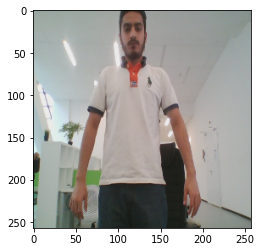

In [3]:
# Load the image
img = cv2.imread("/content/drive/My Drive/innopolis/1st year courses/2nd term/CV/GP/data/pose.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
new_im = cv2.resize(img, (257,257)).reshape((1, 257, 257, 3))
new_im = new_im.astype(np.float32)
plt.imshow(new_im[0]/255)

In [0]:
# Load TFLite model and allocate tensors.
path = "/content/drive/My Drive/innopolis/1st year courses/2nd term/CV/GP/posenet.tflite"
interpreter = tf.lite.Interpreter(model_path=path)
interpreter.allocate_tensors()

In [0]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [0]:
# Test model on the image.
input_index = interpreter.get_input_details()[0]['index']   # get the index
interpreter.set_tensor(input_index, new_im)
interpreter.invoke()

In [7]:
# get the output of the model
output_data = interpreter.get_tensor(output_details[0]['index'])    # heatmaps
output_offset = interpreter.get_tensor(output_details[1]['index'])    #offsets vectors
output_data = output_data[0]    # remove the first dimension for easier processing
output_offset = output_offset[0]
print(output_data.shape)    # check the shape of the output
print(output_offset.shape)


(9, 9, 17)
(9, 9, 34)


In [0]:
# sigmoid function
def sigmoid(a):
  return 1/(1 + np.exp(-a))
# Reference
# https://www.geeksforgeeks.org/implement-sigmoid-function-using-numpy/

In [0]:
def get_keypoints(heatmaps, offsets, output_stride=32):
        """
        params
        heatmaps: the heatmap output of the model
        offsets:  the offset vectors output of the model
        output_stride: depend on the output size of the model
        return
        keypoints: list of objects contain x,y and confidence for each keypoint
        """
        scores = sigmoid(heatmaps) # step1: sigmoid
        num_keypoints = scores.shape[2]   # 17
        heatmap_positions = []
        offset_vectors = []
        confidences = []
        for k in range(num_keypoints): # loop all the keypoints
            x,y = np.unravel_index(np.argmax(scores[:,:,k]), scores[:,:,k].shape) # get the x,y position
            confidences.append(scores[x,y,k])
            #print(scores[x,y,k])
            offset_vector = (offsets[y,x,k], offsets[y,x,num_keypoints+k])  # the offset_vector #todo try x,y
            heatmap_positions.append((x,y))   # store the indicies of the max
            offset_vectors.append(offset_vector)
        image_positions = np.add(np.array(heatmap_positions) * output_stride, offset_vectors)
        keypoints = [KeyPoint(i, pos, confidences[i]) for i, pos in enumerate(image_positions)]
        return keypoints

In [0]:
# dictionary for display
PARTS = {
    0: 'NOSE',
    1: 'LEFT_EYE',
    2: 'RIGHT_EYE',
    3: 'LEFT_EAR',
    4: 'RIGHT_EAR',
    5: 'LEFT_SHOULDER',
    6: 'RIGHT_SHOULDER',
    7: 'LEFT_ELBOW',
    8: 'RIGHT_ELBOW',
    9: 'LEFT_WRIST',
    10: 'RIGHT_WRIST',
    11: 'LEFT_HIP',
    12: 'RIGHT_HIP',
    13: 'LEFT_KNEE',
    14: 'RIGHT_KNEE',
    15: 'LEFT_ANKLE',
    16: 'RIGHT_ANKLE'
}

In [11]:
class KeyPoint():
    """store data and display it for every keypoint"""
    def __init__(self, index, pos, v):
        x, y = pos
        self.x = x
        self.y = y
        self.index = index
        self.body_part = PARTS.get(index)
        self.confidence = v

    def point(self):
        return int(self.y), int(self.x)

    def to_string(self):
        return 'part: {} location: {} confidence: {}'.format(
            self.body_part, (self.x, self.y), self.confidence)

ERROR! Session/line number was not unique in database. History logging moved to new session 59


In [0]:
keypoints = get_keypoints(output_data, output_offset)

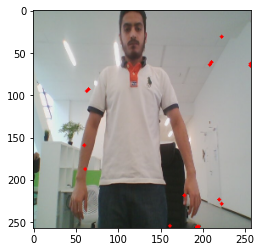

In [18]:
# Draw points on the image 
draw_on = cv2.resize(img, (257,257))
for i in keypoints:
  x, y = i.point()
  cv2.circle(draw_on, (y,x), 2, (255,0,0), -1)

plt.imshow(draw_on)
